In [ ]:
!pip install d2l==1.0.0-alpha1.post0

In [ ]:
from d2l import torch as d2l

Generative Adversarial Networks (GANs)
======
This code implements a Deep Convolutional GAN (DCGAN), a GAN with only convolutional layers in the encoder and decoder.

In [ ]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

Parameter Settings
-------------------


In [ ]:
latent_dims = 10
num_epochs = 20
batch_size = 256
learning_rate = 2e-3
use_gpu = True

MNIST Data Loading
-------------------

MNIST est un dataset d'images de chiffres de 0 à 9 en niveaux de gris de 28x28.

Nous les mettons à l'échelle 64x64 afin de pouvoir disposer d'une architecture plus profonde avec davantage d'étapes de sous-échantillonnage.

Les images sont normalisées et centrées autour de 0, ce qui permet d'obtenir une légère amélioration des performances lors de l'entraînement.




In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 278691204.33it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39025674.56it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 141062912.20it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 7014185.85it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



GAN Definition
-----------------------
Construction d'un GAN a la main avec des couches purement convolutionnelles.

In [ ]:
class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x

generator = Generator()
discriminator = Discriminator()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 12656257 and discriminator: 11033985


Train GAN
--------

(l'apprenttisage prend environ 10 min sur un GPU de Colab)

Epoch [20 / 20] average loss generator vs. discrim.: 3.332704 vs. 0.330401


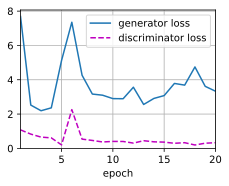

In [ ]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, None],
                        legend=['generator loss', 'discriminator loss'])

print('Training ...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
        fake_image_batch = generator(latent)

        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    animator.add(epoch + 1, (gen_loss_avg[-1], disc_loss_avg[-1]))


print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
        (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))

Plot Training Curves
--------------------

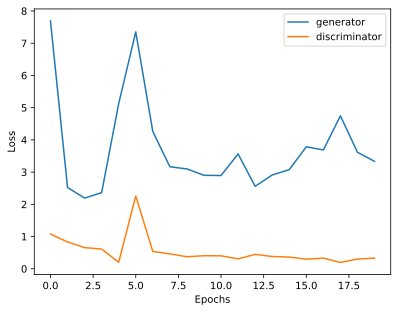

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Interpolate in Latent Space
----------------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


In [ ]:


generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, 100, 1, 1, device=device)
latent_2 = torch.randn(1, 100, 1, 1, device=device)


IndexError: ignored

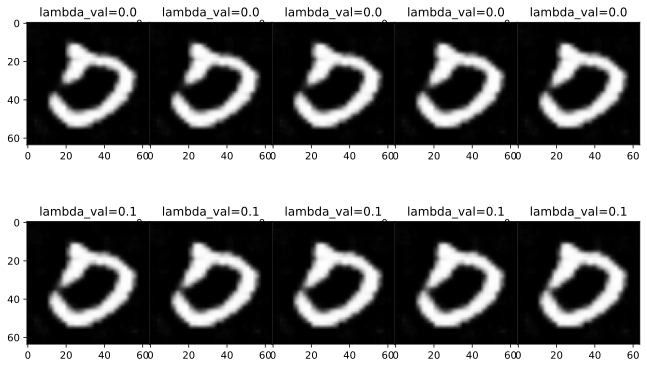

In [ ]:

# interpolation lambdas
lambda_range=np.linspace(0,1,100)

fig, axs = plt.subplots(2,5, figsize=(11, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)

    inter_image = to_img(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show()

Sample Latent Vector from Prior (GAN as Generator)
-------------------------------------------------

GANs usually generate higher-quality results than VAEs or plain Autoencoders, since the distribution of generated digits is more focused on the modes of the real data distribution (see tutorial slides). However, they are harder to train and don't have an encoder, which means the inference of a latent code from a given image is not possible.

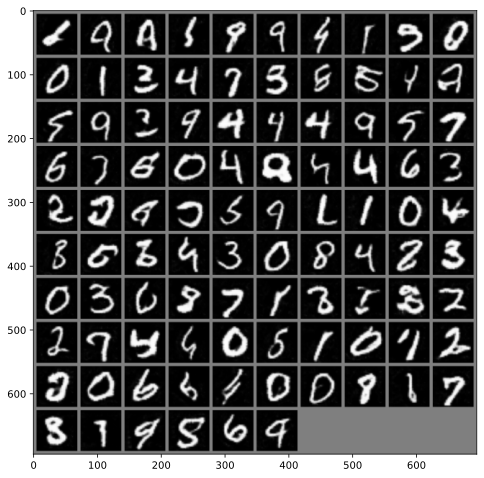

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

with torch.no_grad():

    # sample latent vectors from the standard normal distribution
    latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
    fake_image_batch = generator(latent)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data[:100],10,5))
    plt.show()